#Task

Imagine working for a food delivery company such as Glovo, Just Eat, or Deliveroo. Your task is to design a system capable of estimating the total delivery
time (in minutes) of an order. This estimate should be displayed to the customer
immediately after confirming the purchase. Given the availability of three pos-
sible models—Linear Regression, Logistic Regression, and Decision Trees—the
following describes the complete design process, from problem definition to production deployment.

#Data and Feature Engineering
To build an accurate predictive model, several factors that influence delivery
time must be considered. The proposed features are:

1.   Distance between the client and the restaurant (km);
2.   Distance between the rider and the restaurant at the moment of assignment (km);
3.   Estimated food preparation time (minutes);
4.   Traffic intensity (numerical scale from 1 to 10);
5.   Average vehicle speed (km/h);
6.   Type of day (binary variable: festive vs. ordinary);
7.   Order load ratio (current number of orders divided by the restaurant’s maximum order
capacity);
8.   Time of day (categorized into 12 two-hour intervals);
9.   Weather (sun 1, rain 0);
10.  Time predicted in the history of the company’s records (minutes)

#Model Selection
Among the available options, Linear Regression is selected as the preferred
model. This choice is motivated by its simplicity, interpretability, and effective-
ness in estimating continuous values such as time. The linear model provides
a clear understanding of how each feature affects the delivery time, making it
easier to monitor and improve the system over time. Although Decision Trees
could capture nonlinear relationships, the linear regression model offers greater
stability and generalization capabilities, especially in the initial design phase.

#System Operation in Production
Once deployed, the system would operate as follows:
###Input collection:
– Restaurants provide static or semi-static information such as prepa-
ration time, day type, operating hours, and order load ratio.
– External APIs (e.g., Google Maps) supply dynamic data such as dis-
tances and traffic estimates.
– The company system (e.g., Glovo backend) provides the average ve-
hicle speed based on fleet data.
2
###Prediction: When an order is confirmed, the system automatically gath-
ers all relevant features, processes them through the trained linear regres-
sion model, and generates an estimated delivery time.
###Output: The estimated delivery time is displayed to the user in real
time, and the actual outcome is stored for continuous model retraining
and performance monitoring.
This system would thus allow the company to provide accurate and adaptive
delivery time estimates, improving customer satisfaction and operational effi-
ciency.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     validation_curve, ValidationCurveDisplay,
                                     RandomizedSearchCV, cross_validate)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor

In [ ]:
csv_file_path = '/content/synthetic_delivery_dataset_updated.csv'
# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path)
print("\nDataset loaded successfully.")

# Display the first 5 rows
print("\nFirst 5 rows of the DataFrame:")
display(df.head(16))

# Display data types
print("\nData types of each column:")
display(df.info())

# Check for missing values
print("\nMissing values per column:")
display(df.isnull().sum())


Dataset loaded successfully.

First 5 rows of the DataFrame:


,distance_client_restaurant_km,distance_rider_restaurant_km,est_prep_time_min,traffic_intensity,avg_vehicle_speed_kmh,is_festive_day,order_load_ratio,time_of_day_interval,weather,historical_pred_time_min
0,0.917,2.394,22.1,5,26.0,0,0.265,12:00-13:59,1,35.4
1,2.080,4.164,23.2,5,19.1,0,0.125,06:00-07:59,1,49.0
2,1.732,4.068,40.9,2,26.3,1,0.445,20:00-21:59,0,69.6
3,3.586,3.703,27.1,4,24.8,0,0.342,14:00-15:59,1,58.2
4,3.428,2.611,30.2,7,19.7,0,0.604,08:00-09:59,1,58.8
5,2.173,2.925,30.1,4,29.5,0,0.366,12:00-13:59,1,40.9
6,1.046,4.452,39.0,9,11.4,0,0.416,18:00-19:59,0,84.9
7,1.410,2.002,19.0,3,20.6,1,0.425,04:00-05:59,1,33.9
8,4.802,2.096,40.3,3,31.2,0,0.574,12:00-13:59,1,67.0
9,1.594,3.905,26.5,3,26.8,0,0.347,20:00-21:59,1,48.5



Data types of each column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   distance_client_restaurant_km  20000 non-null  float64
 1   distance_rider_restaurant_km   20000 non-null  float64
 2   est_prep_time_min              20000 non-null  float64
 3   traffic_intensity              20000 non-null  int64  
 4   avg_vehicle_speed_kmh          20000 non-null  float64
 5   is_festive_day                 20000 non-null  int64  
 6   order_load_ratio               20000 non-null  float64
 7   time_of_day_interval           20000 non-null  object 
 8   weather                        20000 non-null  int64  
 9   historical_pred_time_min       20000 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 1.5+ MB


None


Missing values per column:


,0
distance_client_restaurant_km,0
distance_rider_restaurant_km,0
est_prep_time_min,0
traffic_intensity,0
avg_vehicle_speed_kmh,0
is_festive_day,0
order_load_ratio,0
time_of_day_interval,0
weather,0
historical_pred_time_min,0


#Exploratory data analysis (eda)

In [ ]:
X = df.drop('historical_pred_time_min', axis=1)
y = df['historical_pred_time_min']
display(X.head())
display(y.head())

,distance_client_restaurant_km,distance_rider_restaurant_km,est_prep_time_min,traffic_intensity,avg_vehicle_speed_kmh,is_festive_day,order_load_ratio,time_of_day_interval,weather
0,0.917,2.394,22.1,5,26.0,0,0.265,12:00-13:59,1
1,2.080,4.164,23.2,5,19.1,0,0.125,06:00-07:59,1
2,1.732,4.068,40.9,2,26.3,1,0.445,20:00-21:59,0
3,3.586,3.703,27.1,4,24.8,0,0.342,14:00-15:59,1
4,3.428,2.611,30.2,7,19.7,0,0.604,08:00-09:59,1


,historical_pred_time_min
0,35.4
1,49.0
2,69.6
3,58.2
4,58.8


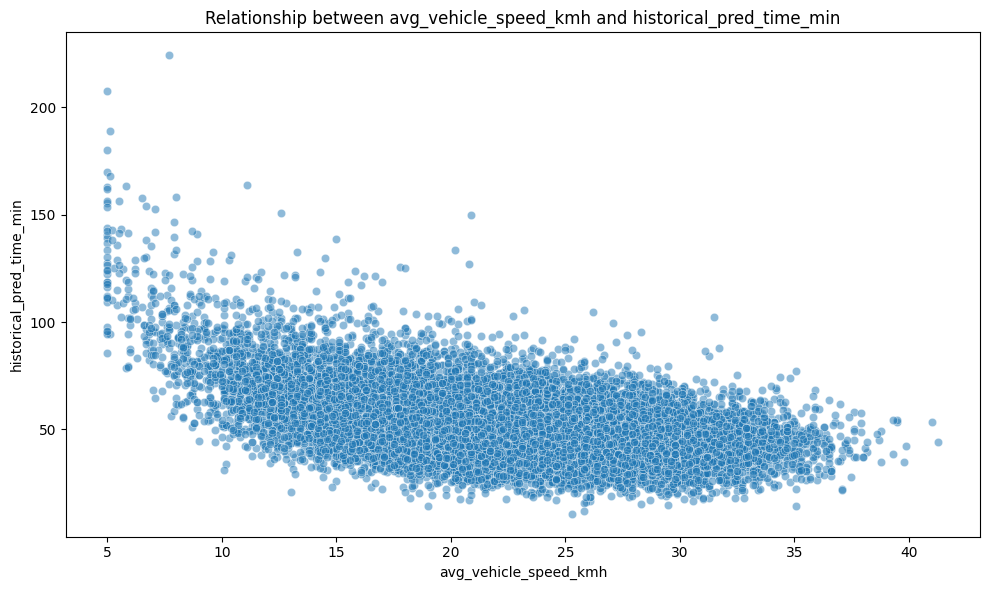

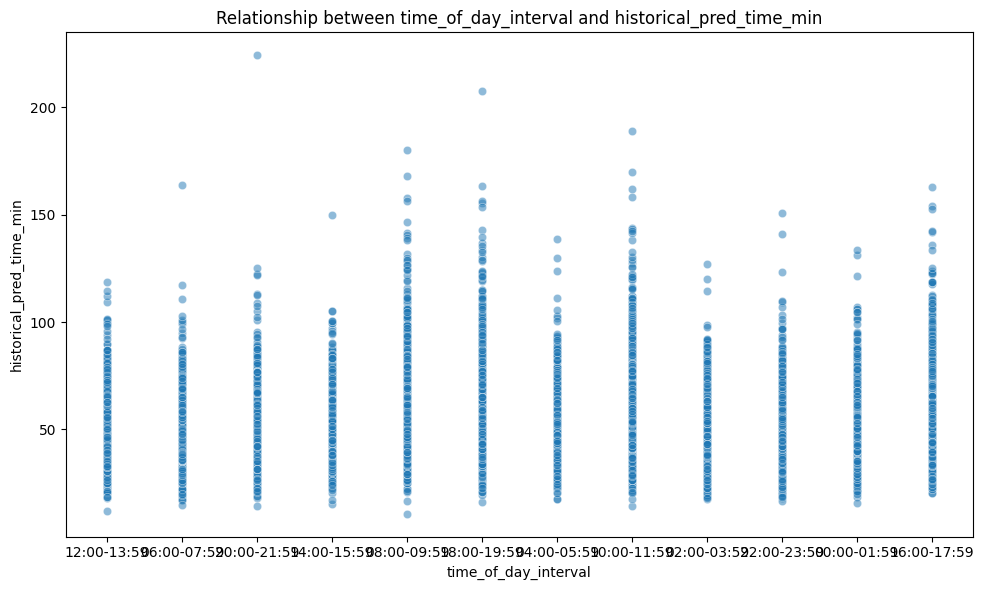

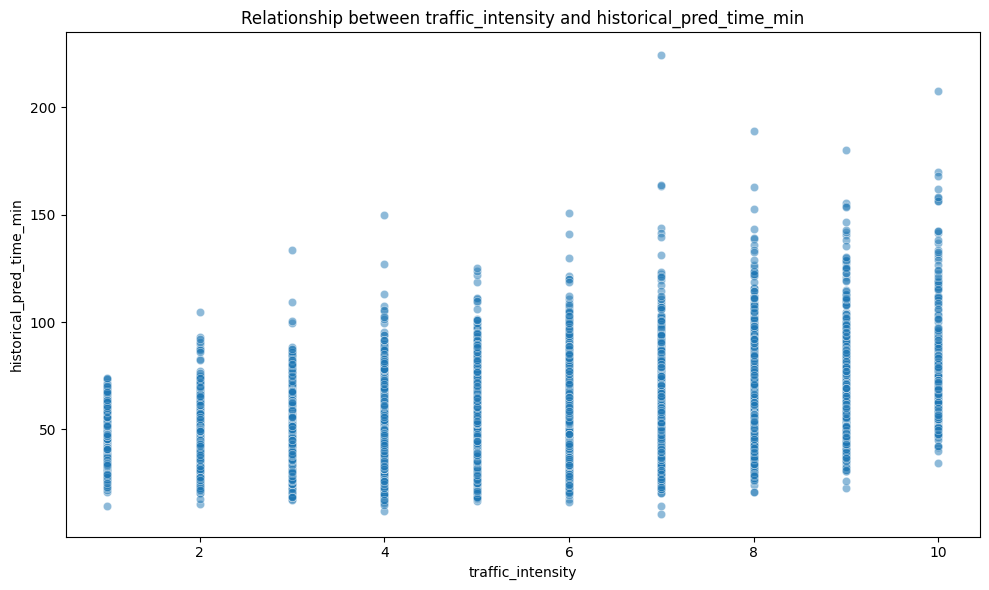

In [ ]:
# Visualize relationships between some features and the target variable
features_for_viz = ['avg_vehicle_speed_kmh', 'time_of_day_interval', 'traffic_intensity']

for feature in features_for_viz:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature, y='historical_pred_time_min', alpha=0.5)
    plt.title(f'Relationship between {feature} and historical_pred_time_min')
    plt.xlabel(feature)
    plt.ylabel('historical_pred_time_min')
    plt.tight_layout()
    plt.show()

*As we can see from the first graph of the relationship between Historical predicted times and average speed of the vehicle used, not every relationship is linear. Thus we conclude that linear regression is an over-simplified model for this dataset, and we could train a model that catches even non-linear relationship, for example a decision tree*.

In [ ]:
# Not recommended to run this cell because of the size of the dataset

'''
sns.pairplot(X.join(y), hue = 'historical_pred_time_min')
plt.suptitle('Pairplot of Dataset by historical_pred_time_min Class', y=1.02)
plt.show()
'''

"\nsns.pairplot(X.join(y), hue = 'historical_pred_time_min')\nplt.suptitle('Pairplot of Dataset by historical_pred_time_min Class', y=1.02)\nplt.show()\n"

,distance_client_restaurant_km,distance_rider_restaurant_km,est_prep_time_min,traffic_intensity,avg_vehicle_speed_kmh,is_festive_day,order_load_ratio,weather,time_of_day_interval_00:00-01:59,time_of_day_interval_02:00-03:59,time_of_day_interval_04:00-05:59,time_of_day_interval_06:00-07:59,time_of_day_interval_08:00-09:59,time_of_day_interval_10:00-11:59,time_of_day_interval_12:00-13:59,time_of_day_interval_14:00-15:59,time_of_day_interval_16:00-17:59,time_of_day_interval_18:00-19:59,time_of_day_interval_20:00-21:59,time_of_day_interval_22:00-23:59
0,0.917,2.394,22.1,5,26.0,0,0.265,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.080,4.164,23.2,5,19.1,0,0.125,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.732,4.068,40.9,2,26.3,1,0.445,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.586,3.703,27.1,4,24.8,0,0.342,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.428,2.611,30.2,7,19.7,0,0.604,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


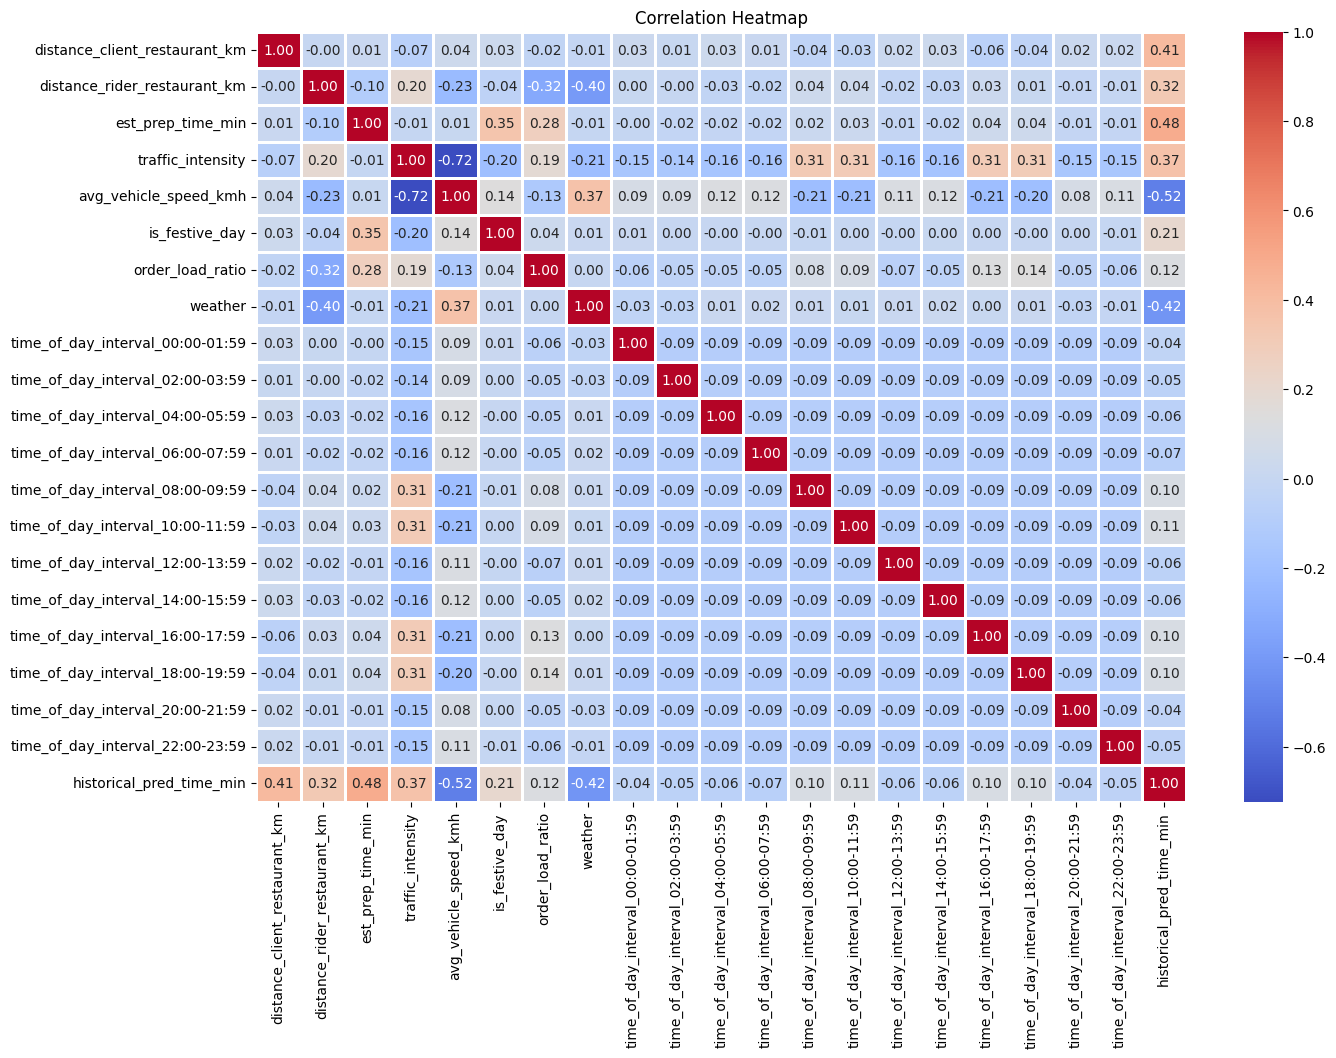

In [ ]:
# Defining a function to convert time of day interval into tuple
def orario_a_tuple(orario_str):

    inizio, fine = orario_str.split('-')

    h1, m1 = map(int, inizio.strip().split(':'))
    ora_inizio = h1 + m1/60

    h2, m2 = map(int, fine.strip().split(':'))
    ora_fine = h2 + m2/60

    return (ora_inizio, ora_fine)


# If not already done apply the function orario_a_tuple

#if type(df['time_of_day_interval'][0]) != tuple:
      #df['orario_tuple'] = df['time_of_day_interval'].apply(orario_a_tuple)
      #df['time_of_day_interval'] = df['orario_tuple']
      #X = X.drop('orario_tuple', axis=1)



# Using OneHotEncoder to convert every time interval
encoder = OneHotEncoder(sparse_output=False)

orari_encoded = encoder.fit_transform(df[['time_of_day_interval']])

nomi_colonne = encoder.get_feature_names_out(['time_of_day_interval'])

df_encoded = pd.DataFrame(orari_encoded, columns=nomi_colonne, index=df.index)

X1 = pd.concat([df, df_encoded], axis=1)
X2 = X1.drop('time_of_day_interval', axis=1)
X3 = X2.drop('historical_pred_time_min', axis=1)
display(X3.head())

# Correlation matrix with visualization

corr_dataset = (X3).join(y)
correlation_matrix = corr_dataset.corr()

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.8)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# let's scale X3
scaler = StandardScaler()
X4 = scaler.fit_transform(X3)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size = 0.2, random_state = 0)

...linear regression trained 
mse:  57.42507956898382
rmse:  7.577933726879896


...lasso trained
mse:  64.28807820672401
rmse:  8.017984672392684
(20, 5) (20, 5)


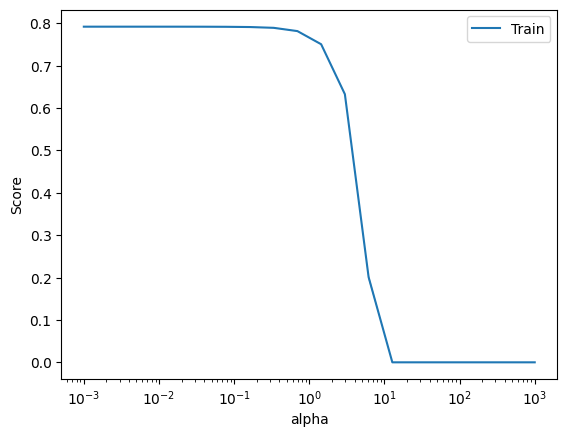

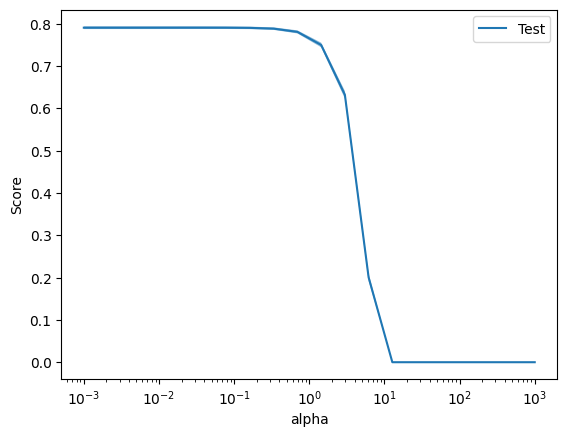

In [ ]:
# fitting our linear model, it should perform in a bad way
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
print('...linear regression trained ')

# model evaluation
y_pred = linreg_model.predict(X_test)

#MSE and RMSE
print('mse: ', mean_squared_error(y_test, y_pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_pred)))

print('\n')

#as we can see, we need some feature engineering with lasso
lasso_model = Lasso(alpha = 1.0)
lasso_model.fit(X_train, y_train)
print('...lasso trained')

# model evaluation
y_pred = lasso_model.predict(X_test)

#MSE and RMSE
print('mse: ', mean_squared_error(y_test, y_pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_pred)))


#tuning the hyperparameters (alpha for lasso)

train_scores, test_scores = validation_curve(
    estimator = Lasso(),
    X = X_train, y = y_train,
    param_name = 'alpha',
    param_range = np.logspace(-3, 3, 20),
    cv = 5,
    n_jobs = -1,
)

print(train_scores.shape, test_scores.shape)

ValidationCurveDisplay.from_estimator(
    estimator = Lasso(),
    X = X_train, y = y_train,
    param_name = 'alpha',
    param_range = np.logspace(-3, 3, 20),
    cv = 5,
    score_type = "train"
)

ValidationCurveDisplay.from_estimator(
    estimator = Lasso(),
    X = X_train, y = y_train,
    param_name = 'alpha',
    param_range = np.logspace(-3, 3, 20),
    cv = 5,
    score_type = "test"
)

plt.show()

In [ ]:
#GridSearchCV on the lasso model
param_grid = {'alpha': np.logspace(-3, 2, 20) }

grid_search1 = GridSearchCV(
    estimator = Lasso(),
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    n_jobs = -1
)

grid_search1.fit(X_train, y_train)

#best hyperparams for our model
best_params = grid_search1.best_params_
best_scores = grid_search1.best_score_
print(f"best params: {best_params['alpha']} \n best_scores: {best_scores}")

#fitting best lasso with hypermarams
best_lasso_model = Lasso(best_params['alpha'])
best_lasso_model.fit(X_train, y_train)

y_pred = best_lasso_model.predict(X_test)

#MSE and RMSE for best lasso
print('mse for best lasso: ', mean_squared_error(y_test, y_pred))
print('rmse for best lasso: ', np.sqrt(mean_squared_error(y_test, y_pred)))



best params: 0.011288378916846888 
 best_scores: -50.20743270188026
mse for best lasso:  57.465093146962
rmse for best lasso:  7.5805734048924025


In [ ]:
#zeroed params by lasso
print(X4.shape)
print("columns to drop: ", np.array(pd.DataFrame(X4).columns)[best_lasso_model.coef_ == 0])
print(X3.iloc[:, [10, 13, 14]])
X3 = X3.drop(columns=X3.columns[[10, 13, 14]])
X3.head()

(20000, 20)
columns to drop:  [10 13 14]
       time_of_day_interval_04:00-05:59  time_of_day_interval_10:00-11:59  \
0                                   0.0                               0.0   
1                                   0.0                               0.0   
2                                   0.0                               0.0   
3                                   0.0                               0.0   
4                                   0.0                               0.0   
...                                 ...                               ...   
19995                               0.0                               0.0   
19996                               0.0                               0.0   
19997                               0.0                               0.0   
19998                               0.0                               0.0   
19999                               0.0                               0.0   

       time_of_day_interval_12:00-

,distance_client_restaurant_km,distance_rider_restaurant_km,est_prep_time_min,traffic_intensity,avg_vehicle_speed_kmh,is_festive_day,order_load_ratio,weather,time_of_day_interval_00:00-01:59,time_of_day_interval_02:00-03:59,time_of_day_interval_06:00-07:59,time_of_day_interval_08:00-09:59,time_of_day_interval_14:00-15:59,time_of_day_interval_16:00-17:59,time_of_day_interval_18:00-19:59,time_of_day_interval_20:00-21:59,time_of_day_interval_22:00-23:59
0,0.917,2.394,22.1,5,26.0,0,0.265,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.080,4.164,23.2,5,19.1,0,0.125,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.732,4.068,40.9,2,26.3,1,0.445,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3.586,3.703,27.1,4,24.8,0,0.342,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3.428,2.611,30.2,7,19.7,0,0.604,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#let's fit the regressor tree
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = 0.2, random_state = 0)
DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)

# model evaluation
y_pred = DT.predict(X_test)

#MSE and RMSE
print('mse: ', mean_squared_error(y_test, y_pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_pred)))


mse:  65.1873825
rmse:  8.073870354421107


In [ ]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

# RandomSearch
random_search = RandomizedSearchCV(
    estimator = DecisionTreeRegressor(),
    param_distributions = param_grid,
    n_iter = 50,
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    random_state = 0,
    verbose = 1
)

random_search.fit(X_train, y_train)

# GridSearch
grid_search = GridSearchCV(
 estimator=DecisionTreeRegressor(),
 param_grid=param_grid,
 cv=5,
 scoring='neg_mean_squared_error'
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best hyperparameters
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Best cross-validation score
print("\nBest cross-validation mse:")
print(abs(grid_search.best_score_))

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_search.best_estimator_
Y_pred_tuned = best_model.predict(X_test)
mse_tuned = mean_squared_error(y_test, Y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, Y_pred_tuned))

# Print the mse on the test set with tuned hyperparameters
print(f"mse on the test set with tuned hyperparameters: {mse_tuned:.2f}")
print(f"rmse on the test set with tuned hyperparameters: {rmse_tuned:.2f}")

Best hyperparameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 10}

Best cross-validation mse:
47.859925632668805
mse on the test set with tuned hyperparameters: 48.89
rmse on the test set with tuned hyperparameters: 6.99


{'Dummy': array([249.38160506, 225.60651894, 248.00296595, 236.89670844,
       243.21015008]), 'RandomSearch': array([47.84728316, 49.20831526, 48.00770405, 46.42563078, 47.81069492]), 'GridSearch': array([47.84728316, 49.20831526, 48.00770405, 46.42563078, 47.81069492]), 'Lasso': array([50.57800831, 47.51353816, 51.9102855 , 49.43383302, 51.60149852])}

Cross-Validation MSE (5-fold):
            Dummy  RandomSearch  GridSearch      Lasso
count    5.000000      5.000000    5.000000   5.000000
mean   240.619590     47.859926   47.859926  50.207433
std      9.711466      0.987393    0.987393   1.791367
min    225.606519     46.425631   46.425631  47.513538
25%    236.896708     47.810695   47.810695  49.433833
50%    243.210150     47.847283   47.847283  50.578008
75%    248.002966     48.007704   48.007704  51.601499
max    249.381605     49.208315   49.208315  51.910286


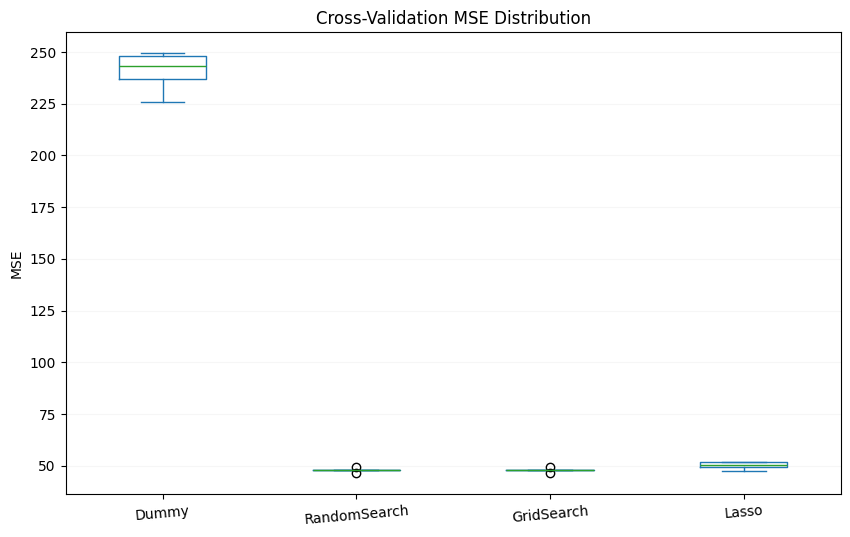

In [ ]:
models = {
    'Dummy': DummyRegressor(strategy="mean"),
    'RandomSearch': random_search.best_estimator_,
    'GridSearch': grid_search.best_estimator_,
    'Lasso' : grid_search1.best_estimator_
}

cv_results = {}
for name, model in models.items():
    cv_scores = cross_validate(
        model,
        X_train,
        y_train,
        cv = 5,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    )
    cv_results[name] = abs(cv_scores['test_score'])

print(cv_results)

# Crea DataFrame per visualizzazione
cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation MSE (5-fold):")
print(cv_df.describe())

# Plot boxplot
cv_df.plot.box(figsize = (10, 6))
plt.ylabel('MSE')
plt.title('Cross-Validation MSE Distribution')
plt.xticks(rotation = 5)
plt.grid(axis = 'y', alpha = 0.1)
plt.show()

{'RandomSearch': array([47.84728316, 49.20831526, 48.00770405, 46.42563078, 47.81069492]), 'GridSearch': array([47.84728316, 49.20831526, 48.00770405, 46.42563078, 47.81069492]), 'Lasso': array([50.57800831, 47.51353816, 51.9102855 , 49.43383302, 51.60149852])}

Cross-Validation MSE (5-fold):
       RandomSearch  GridSearch      Lasso
count      5.000000    5.000000   5.000000
mean      47.859926   47.859926  50.207433
std        0.987393    0.987393   1.791367
min       46.425631   46.425631  47.513538
25%       47.810695   47.810695  49.433833
50%       47.847283   47.847283  50.578008
75%       48.007704   48.007704  51.601499
max       49.208315   49.208315  51.910286


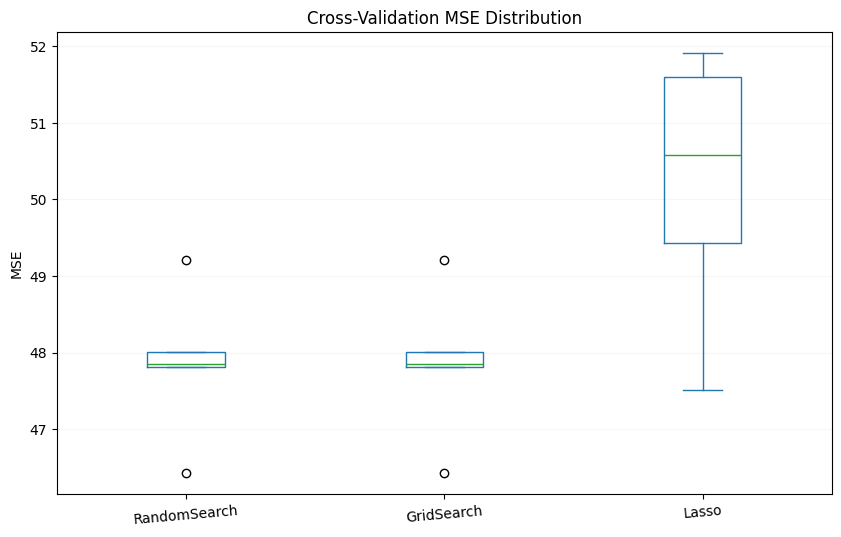

In [ ]:
models = {
    'RandomSearch': random_search.best_estimator_,
    'GridSearch': grid_search.best_estimator_,
    'Lasso' : grid_search1.best_estimator_
}

cv_results = {}
for name, model in models.items():
    cv_scores = cross_validate(
        model,
        X_train,
        y_train,
        cv = 5,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    )
    cv_results[name] = abs(cv_scores['test_score'])

print(cv_results)

# Crea DataFrame per visualizzazione
cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation MSE (5-fold):")
print(cv_df.describe())

# Plot boxplot
cv_df.plot.box(figsize = (10, 6))
plt.ylabel('MSE')
plt.title('Cross-Validation MSE Distribution')
plt.xticks(rotation = 5)
plt.grid(axis = 'y', alpha = 0.1)
plt.show()